In [1]:
import os
print(os.getcwd())
import pandas as pd
import json
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from configs import generate_image_base_dir, celeba_attributes_dict
target_logit = 15
base_dir = os.path.join(generate_image_base_dir, 'generated_facial_images_v3',
                        f"{target_logit}_{celeba_attributes_dict[target_logit]}")


/tmp/pycharm_project_181


In [2]:
def load_json_data(base_dir):
    """
    Load JSON data from the specified base directory.

    Args:
        base_dir (str): Path to the directory containing seed directories and JSON files.

    Returns:
        pd.DataFrame: A DataFrame containing aggregate data from all JSON files.
    """
    records = []

    # Process all subdirectories
    for seed_dir in os.listdir(base_dir):
        seed_path = os.path.join(base_dir, seed_dir)
        if not os.path.isdir(seed_path):
            print(f"Skipping non-directory: {seed_path}")
            continue

        # Process all JSON files in the subdirectory
        for json_file in os.listdir(seed_path):
            if not json_file.endswith(".json"):
                continue
            json_path = os.path.join(seed_path, json_file)

            try:
                # Load JSON data
                with open(json_path, 'r') as f:
                    data = json.load(f)

                # Extract relevant fields
                layer_name = data.get("layer_name")
                channel_id = data.get("channel_id")
                significant_changes = data.get("significant_changes", [])

                for i,change in enumerate(significant_changes[:1]):
                    records.append({
                        "layer_name": layer_name,
                        "channel_id": channel_id,
                        "region": change.get("region"),
                        "change": change.get("change"),
                        "iou_diff": change.get("iou_diff"),
                        "l1": change.get("l1"),
                        "hue_shift": change.get("hue_shift"),
                        "ssim_diff": change.get("ssim_diff"),
                        "composite_score": change.get("composite_score"),
                        "diff_source": change.get("diff_source"),
                        "img_path": data.get("img_path"),
                    })

            except Exception as e:
                print(f"Error reading file {json_path}: {e}")

    # Convert records to a DataFrame
    return pd.DataFrame(records)

df = load_json_data(base_dir)
df

,layer_name,channel_id,region,change,iou_diff,l1,hue_shift,ssim_diff,composite_score,diff_source,img_path
0,b32.conv0.affine,6,eyebrows,deformatted,0.58,None,None,0.00,0.2316,None,/home/xchen/SMOO/generated_images_v3/15_Eyegla...
1,b16.conv1.affine,362,eyebrows,deformatted,0.43,None,None,0.00,0.1711,None,/home/xchen/SMOO/generated_images_v3/15_Eyegla...
2,b16.conv1.affine,113,mouth,deformatted,0.64,None,None,0.00,0.2549,None,/home/xchen/SMOO/generated_images_v3/15_Eyegla...
3,b1024.conv1.affine,3,ears,maintained,0.28,None,None,0.16,0.1479,None,/home/xchen/SMOO/generated_images_v3/15_Eyegla...
4,b64.conv0.affine,231,ears,deformatted,0.53,None,None,0.00,0.2126,None,/home/xchen/SMOO/generated_images_v3/15_Eyegla...
...,...,...,...,...,...,...,...,...,...,...,...
200,b32.conv1.affine,204,necklaces,added,1.00,None,None,0.00,0.4000,None,/home/xchen/SMOO/generated_images_v3/15_Eyegla...
201,b1024.conv1.affine,12,hair,maintained,0.06,None,None,0.28,0.3594,None,/home/xchen/SMOO/generated_images_v3/15_Eyegla...
202,b16.conv1.affine,188,hair,maintained,0.20,None,None,0.25,0.1122,None,/home/xchen/SMOO/generated_images_v3/15_Eyegla...
203,b1024.conv0.affine,48,glasses,maintained,0.04,None,None,0.16,0.2052,None,/home/xchen/SMOO/generated_images_v3/15_Eyegla...


In [3]:
def analyze_layer_channel_frequencies(df):
    """
    Analyze the frequency of layer_name and channel_id in the dataset.

    Args:
        df (pd.DataFrame): Input data containing layer_name and channel_id information.

    Returns:
        pd.DataFrame: A DataFrame summarizing layer and channel frequencies.
    """
    # Group by layer_name and channel_id
    layer_channel_freq = df.groupby(["layer_name", "channel_id"]).size().reset_index(name="frequency")

    # Sort by frequency for better visibility
    return layer_channel_freq.sort_values(by="frequency", ascending=False, ignore_index=True)


df_layer_channel_freq = analyze_layer_channel_frequencies(df)
df_layer_channel_freq

,layer_name,channel_id,frequency
0,b8.conv1.affine,228,9
1,b8.conv0.affine,97,7
2,b16.conv0.affine,325,7
3,b64.conv1.affine,327,6
4,b32.conv1.affine,204,6
...,...,...,...
101,b32.conv0.affine,59,1
102,b256.conv1.affine,109,1
103,b256.conv1.affine,24,1
104,b256.conv0.affine,38,1


In [4]:


# Analyze significant changes
print("\nAnalyzing significant changes...")
change_stats = df.groupby(["region", "change"]).agg(
        frequency=("composite_score", "count"),
        avg_composite_score=("composite_score", "mean")
    ).reset_index()

    # Sort by frequency for better visibility
change_analysis = change_stats.sort_values(by="frequency", ascending=False)
print(change_analysis)


# Analyze significant changes
print("\nAnalyzing significant regions...")
change_stats = df.groupby(["region"]).agg(
        frequency=("composite_score", "count"),
        avg_composite_score=("composite_score", "mean")
    ).reset_index()

    # Sort by frequency for better visibility
change_analysis = change_stats.sort_values(by="frequency", ascending=False)
print(change_analysis)


Analyzing significant changes...
       region       change  frequency  avg_composite_score
3        ears  deformatted         32             0.214959
6    eyebrows  deformatted         21             0.253686
4        ears   maintained         16             0.160013
15       hair  deformatted         16             0.279544
7    eyebrows   maintained         16             0.168437
12    glasses  deformatted         15             0.398427
0       cloth  deformatted         12             0.250958
16       hair   maintained         11             0.190409
13    glasses   maintained         11             0.186627
20      mouth   maintained          9             0.219900
26       skin   maintained          6             0.257117
5        ears      removed          6             0.399533
22       neck   maintained          5             0.321500
25       nose   maintained          4             0.443400
1       cloth   maintained          4             0.080675
18        hat  deforma

/tmp/ipykernel_2092793/395518355.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["layer_channel"] = (


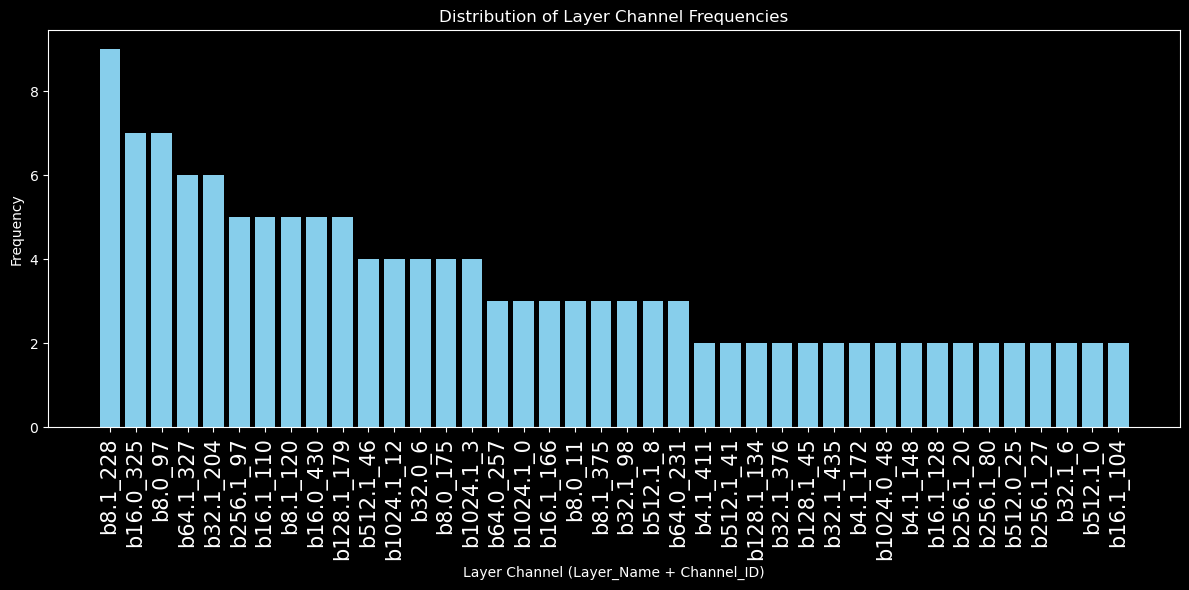

In [5]:
def plot_layer_channel_distribution(df):
    """
    Plot a histogram showing the frequency distribution of layer_name and channel_id.

    Args:
        df (pd.DataFrame): Data containing layer_name and channel_id frequencies.
    """
    # Combine layer name and channel into a single column for easier visualization
    df["layer_channel"] = (
    df["layer_name"].str.replace("conv", "", regex=False)  # Remove "conv"
                    .str.replace(".affine", "", regex=False)  # Remove ".affine"
        + "_" + df["channel_id"].astype(str)  # Append channel ID
    )


    # Sort by frequency for better plotting
    sorted_data = df.sort_values(by="frequency", ascending=False)

    # Plot the histogram
    plt.figure(figsize=(12, 6))  # Adjust size as needed
    plt.bar(sorted_data["layer_channel"], sorted_data["frequency"], color="skyblue")
    plt.xticks(rotation=90, fontsize=15)  # Rotate layer_channel labels for visibility
    plt.xlabel("Layer Channel (Layer_Name + Channel_ID)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Layer Channel Frequencies")
    plt.tight_layout()

    # Save and show the plot
    #output_dir = "./analysis_results"
    #os.makedirs(output_dir, exist_ok=True)
    #plt.savefig(os.path.join(output_dir, "layer_channel_distribution.png"))
    plt.show()

plot_layer_channel_distribution(df_layer_channel_freq[:40])

In [6]:
df_layer_channel_freq[:20]

,layer_name,channel_id,frequency
0,b8.conv1.affine,228,9
1,b8.conv0.affine,97,7
2,b16.conv0.affine,325,7
3,b64.conv1.affine,327,6
4,b32.conv1.affine,204,6
5,b256.conv1.affine,97,5
6,b16.conv1.affine,110,5
7,b8.conv1.affine,120,5
8,b16.conv0.affine,430,5
9,b128.conv1.affine,179,5


In [7]:
def analyze_channel_changes(df, layer_name, channel_id):
    """
    Analyze the distribution of `change` types for a given channel.

    Args:
        df (pd.DataFrame): The DataFrame containing data.
        layer_name (str): The name of the layer.
        channel_id (int): The ID of the channel.

    Returns:
        pd.DataFrame: A DataFrame summarizing the frequency distribution of `change` types.
    """
    # Filter for the specified channel
    channel_df = df[(df["layer_name"] == layer_name) & (df["channel_id"] == channel_id)]

    if channel_df.empty:
        print(f"No data found for layer: {layer_name}, channel: {channel_id}")
        return None

    # Group by `change` and compute the frequency
    change_distribution = channel_df["region"].value_counts().reset_index()
    change_distribution.columns = ["region", "frequency"]

    return change_distribution

def plot_channel_change_distribution(change_distribution, layer_name, channel_id):
    """
    Plot the distribution of `change` types for a specified channel.

    Args:
        change_distribution (pd.DataFrame): Frequency distribution of `change` types.
        layer_name (str): The name of the layer.
        channel_id (int): The ID of the channel.
    """
    if change_distribution is None or change_distribution.empty:
        print("No data available to plot.")
        return

    # Plot the bar chart
    plt.figure(figsize=(10, 6))  # Adjust size as needed
    plt.bar(change_distribution["region"], change_distribution["frequency"], color="lightcoral")
    plt.xlabel("Change Types")
    plt.ylabel("Frequency")
    plt.title(f"Change Types Distribution for {layer_name}_channel_{channel_id}", fontsize=15)
    plt.xticks(rotation=45, ha="right")  # Rotate labels for better visibility
    plt.tight_layout()
    plt.xticks(rotation=45, ha="right")  # Rotate labels for better visibility
    plt.tight_layout()

    # Save and show the plot
    output_dir = "./analysis_results"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f"change_distribution_{layer_name}_channel_{channel_id}.png"))
    plt.show()


In [8]:

def plot_random_channel_images(df, layer_name, channel_id, channel_count=5):
    # Filter DataFrame for the specified layer and channel
    filtered_df = df[(df["layer_name"] == layer_name) & (df["channel_id"] == channel_id)]

    if filtered_df.empty:
        print(f"No data found for layer: {layer_name}, channel: {channel_id}")
        return

    # Randomly sample rows
    sampled_rows = filtered_df.sample(n=min(channel_count, len(filtered_df)))

    for i, (idx, row) in enumerate(sampled_rows.iterrows()):
        img_path = row["img_path"]
        # Load images
        img = plt.imread(img_path.replace("generated_images_v3", "generated_facial_images_v3"))[140:330, 60:600]
        # Titles and plots
        plt.imshow(img)
        plt.title(f"Region: {row['region']}, Change: {row['change']}")
        plt.axis("off")
        plt.show()

def main_single_channel(df, layer_channel_freq_id):

    row = df_layer_channel_freq.iloc[layer_channel_freq_id]

    layer_name = row["layer_name"]  # Specify layer name Specify layer name
    channel_id = row["channel_id"]
    # Analyze the distribution of changes for the specified channel
    print(f"\nAnalyzing changes for layer: {layer_name}, channel: {channel_id}...")
    change_distribution = analyze_channel_changes(df, layer_name, channel_id)
    print(change_distribution)

    # Plot the distribution of changes
    print("\nPlotting changes distribution...")
    plot_channel_change_distribution(change_distribution, layer_name, channel_id)

    plot_random_channel_images(df, layer_name,channel_id, channel_count=5)


Analyzing changes for layer: b8.conv1.affine, channel: 228...
     region  frequency
0   glasses          5
1  eyebrows          2
2      hair          1
3     mouth          1

Plotting changes distribution...


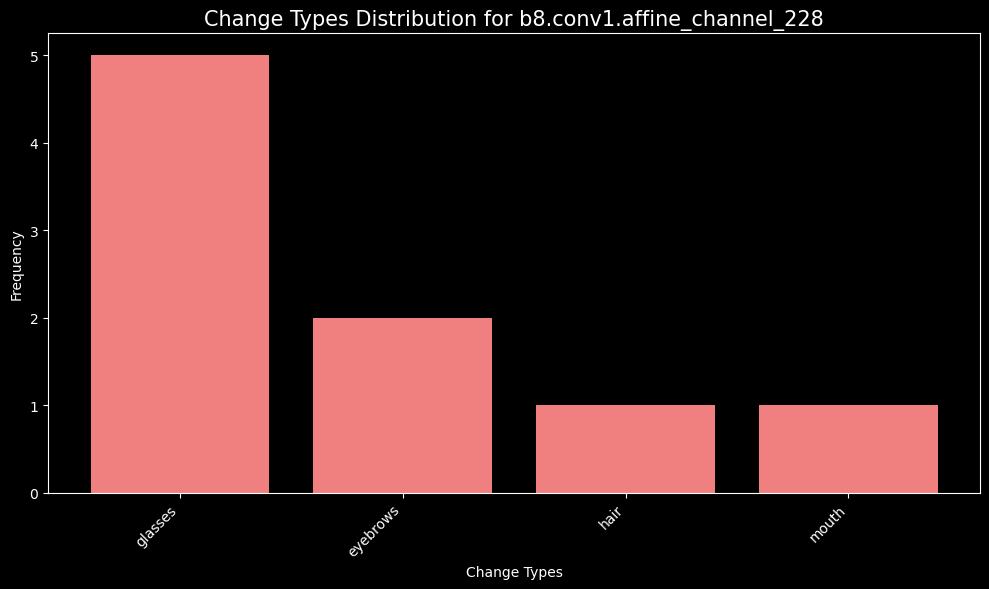

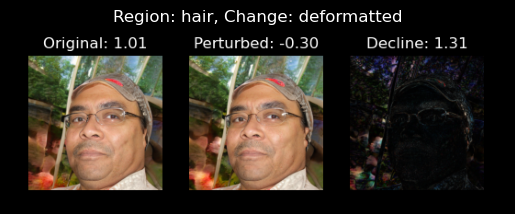

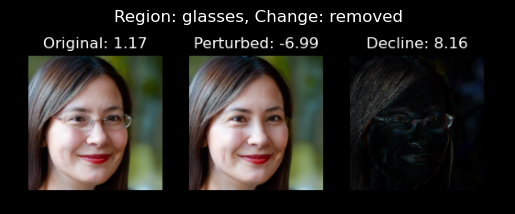

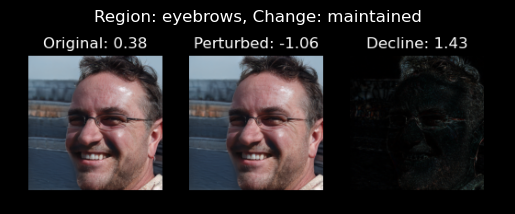

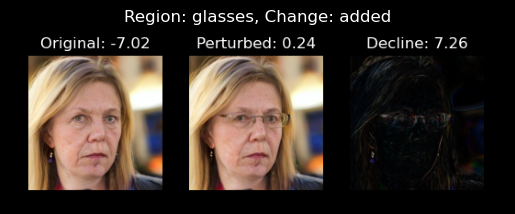

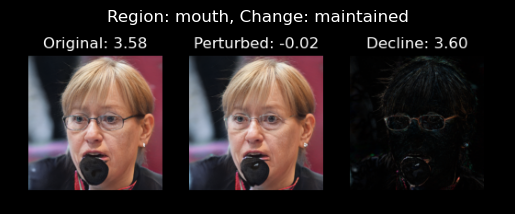

In [9]:
main_single_channel(df, layer_channel_freq_id=0)


Analyzing changes for layer: b8.conv0.affine, channel: 97...
     region  frequency
0  eyebrows          2
1   glasses          2
2      eyes          1
3      hair          1
4     mouth          1

Plotting changes distribution...


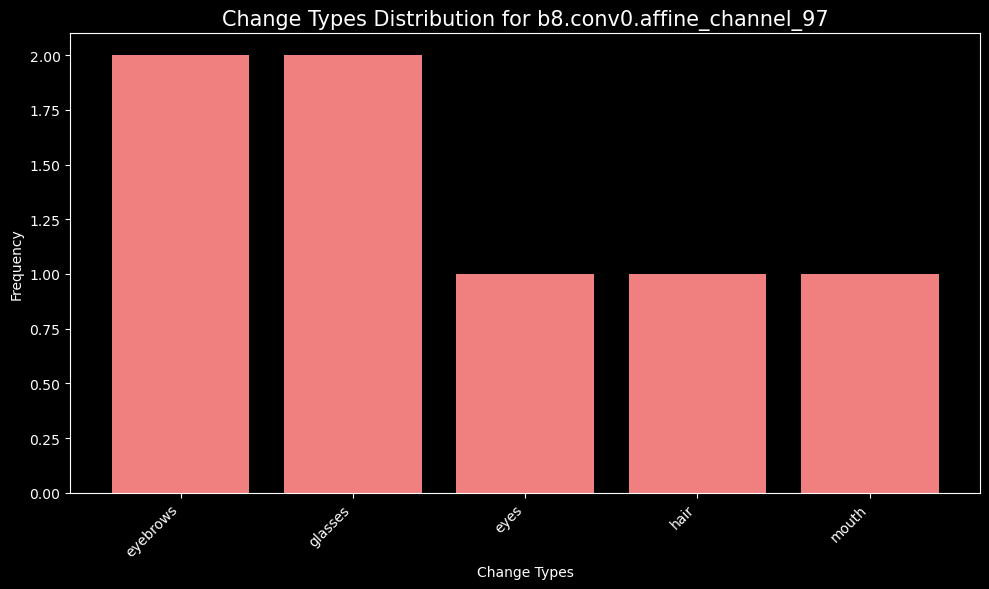

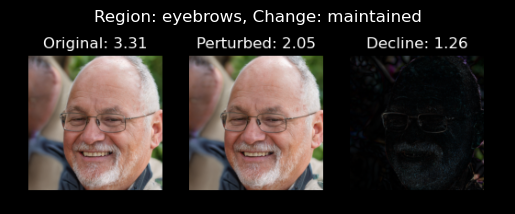

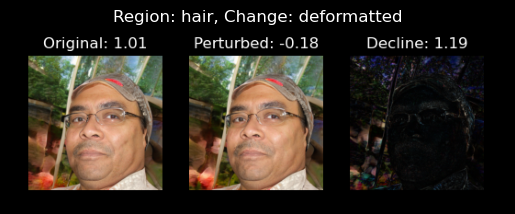

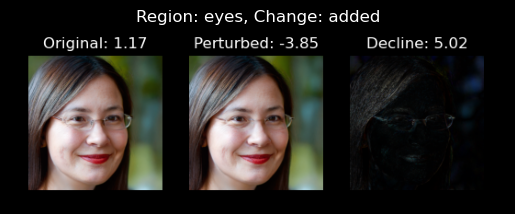

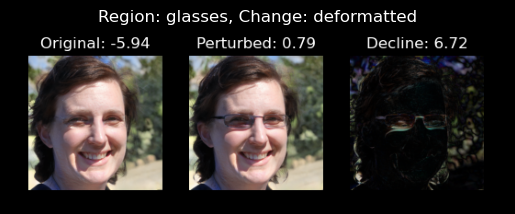

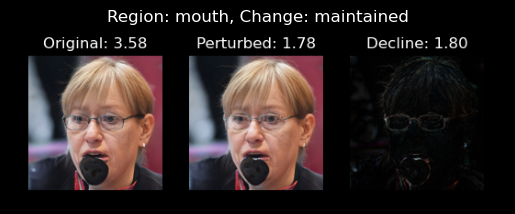

In [10]:
main_single_channel(df, layer_channel_freq_id=1)


Analyzing changes for layer: b16.conv0.affine, channel: 325...
    region  frequency
0  glasses          5
1     skin          1
2     hair          1

Plotting changes distribution...


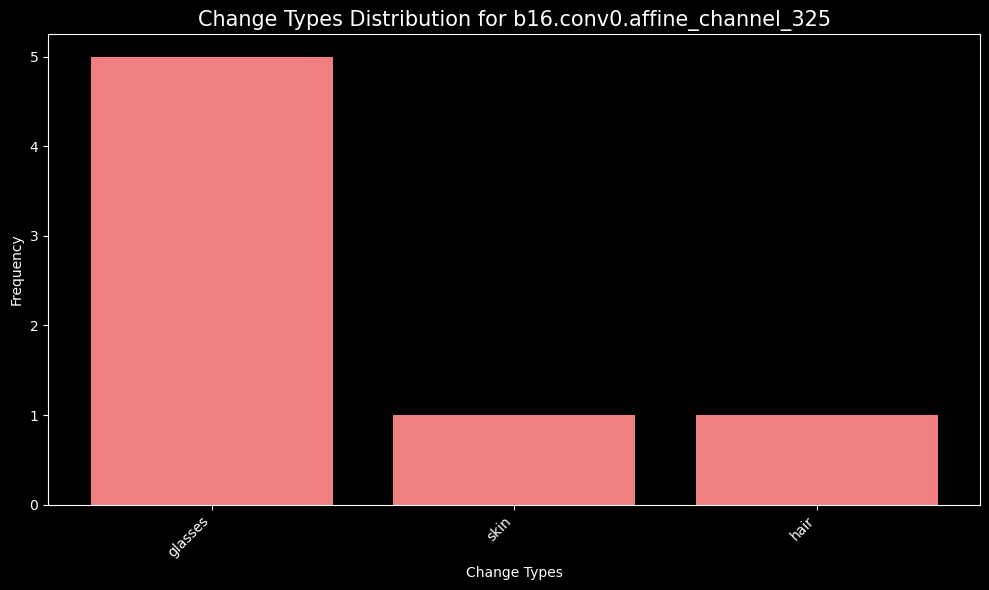

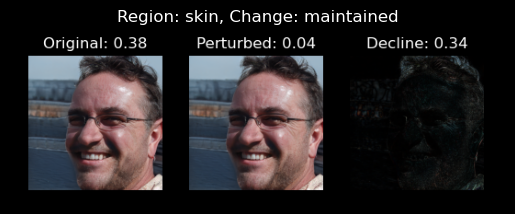

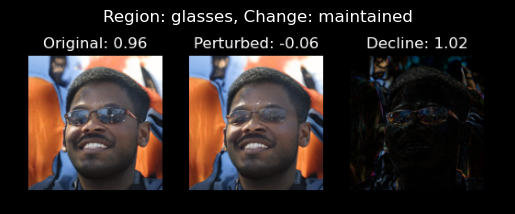

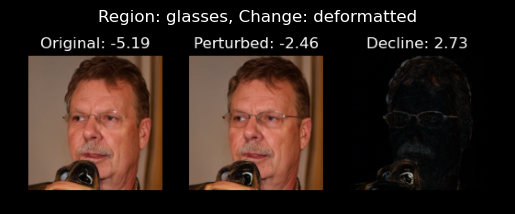

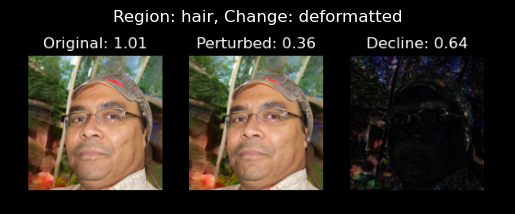

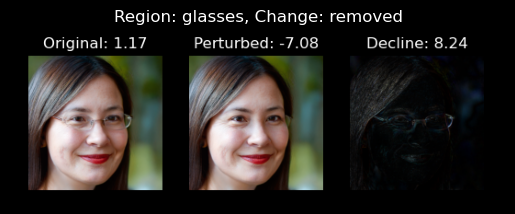

In [11]:
main_single_channel(df, layer_channel_freq_id=2)


Analyzing changes for layer: b64.conv1.affine, channel: 327...
    region  frequency
0  glasses          2
1      hat          1
2     ears          1
3     hair          1
4     eyes          1

Plotting changes distribution...


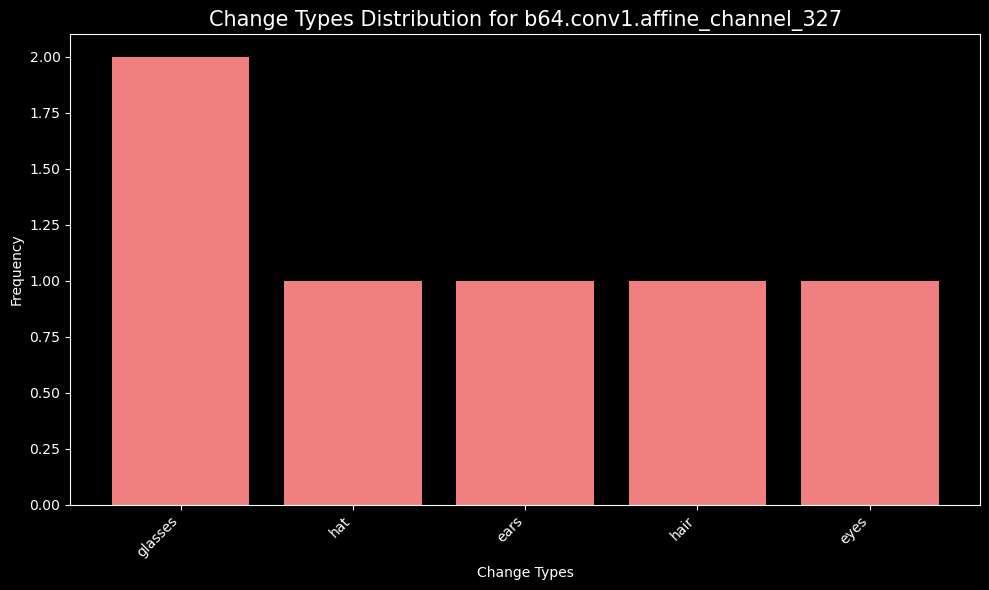

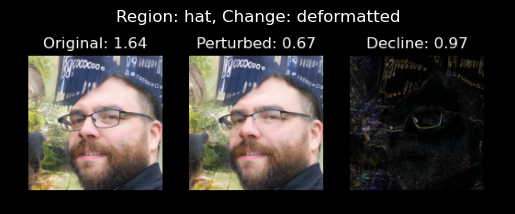

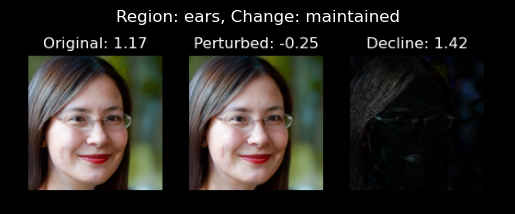

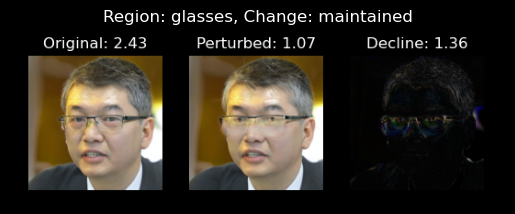

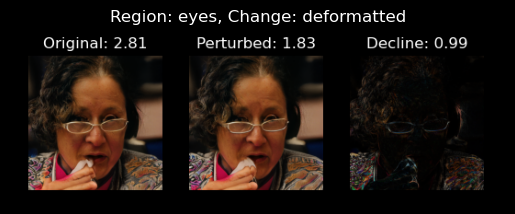

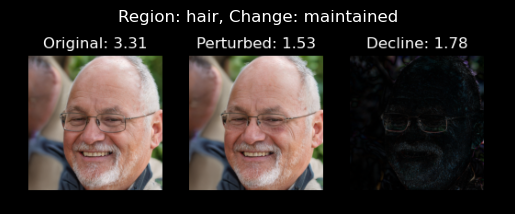

In [12]:
main_single_channel(df, layer_channel_freq_id=3)


Analyzing changes for layer: b32.conv0.affine, channel: 6...
     region  frequency
0  eyebrows          3
1     cloth          1

Plotting changes distribution...


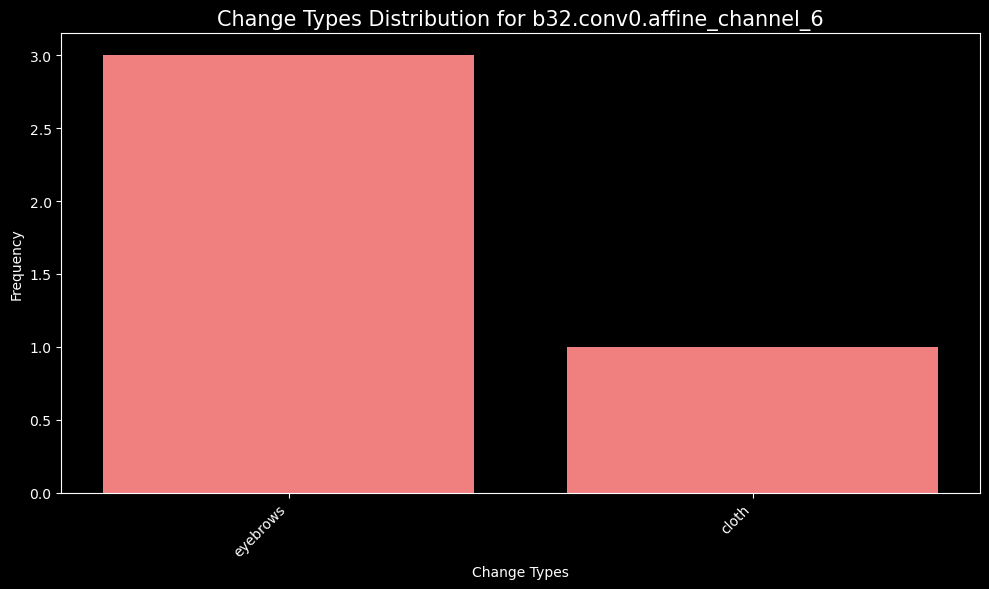

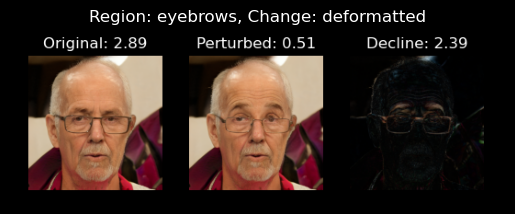

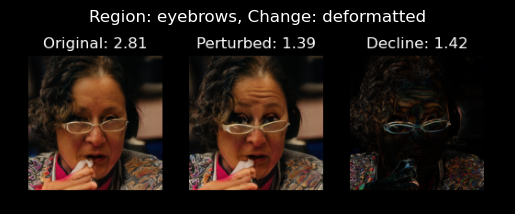

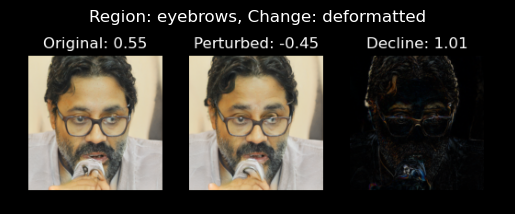

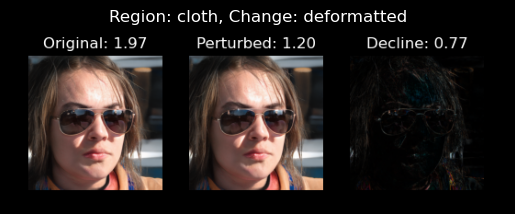

In [13]:
main_single_channel(df, layer_channel_freq_id=12)